# Differentiating voltage data

Differential Voltage Analysis (DVA) and Incremental Capacity Analysis are popular
methods of characterising the degradation state of a cell. PyProBE offers multiple
methods to the user which will be explored in this example.

First import the package and dataset:

In [1]:
import pyprobe
import numpy as np
info_dictionary = {'Name': 'Sample cell',
                   'Chemistry': 'NMC622',
                   'Nominal Capacity [Ah]': 0.04,
                   'Cycler number': 1,
                   'Channel number': 1,}
data_directory = '../../../tests/sample_data/neware'

# Create a cell object
cell = pyprobe.Cell(info=info_dictionary)
cell.add_procedure(procedure_name='Sample',
                   folder_path = data_directory,
                   filename = 'sample_data_neware.parquet')

The break-in cycles of this dataset are at C/10, so can be analysed as pseudo-OCV curves. We're going to look at the last cycle:

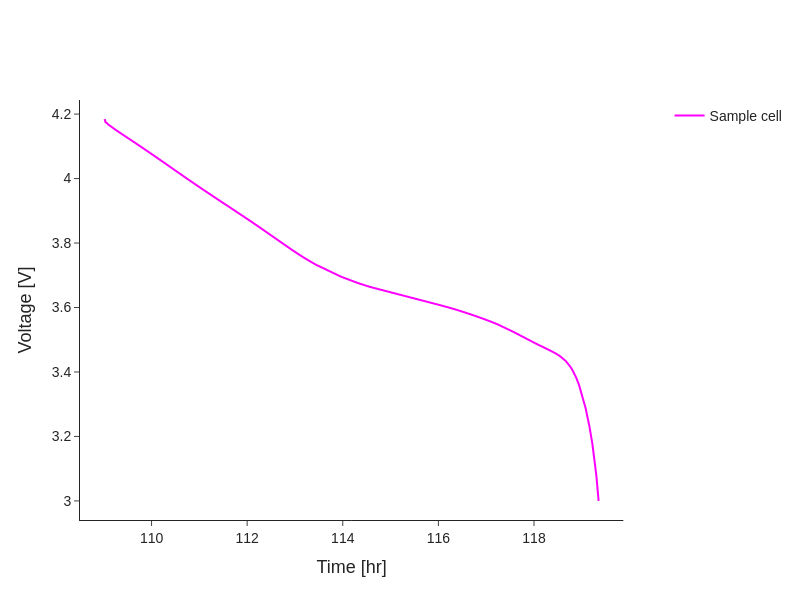

In [2]:
final_cycle= cell.procedure['Sample'].experiment('Break-in Cycles').cycle(-1)
fig = pyprobe.Plot()
fig.add_line(final_cycle.discharge(0), 'Time [hr]', 'Voltage [V]')
fig.show_image()
# fig.show() # This will show the plot interactively, it is commented out for the sake of the documentation

We're going to look at using the finite-difference based differentiation method, first 
on the raw data:

['Capacity [Ah]', 'Voltage [V]', 'd(Voltage [V])/d(Capacity [Ah])']


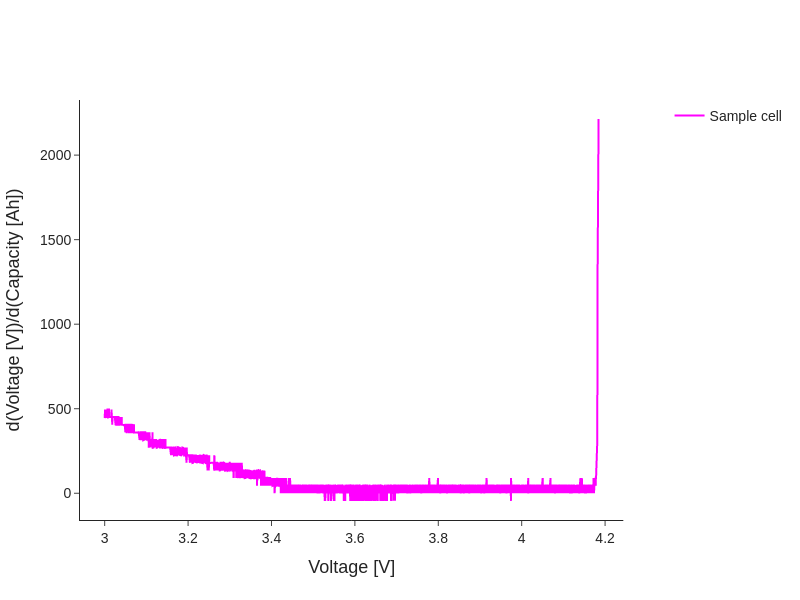

In [3]:
from pyprobe.analysis import differentiation

raw_data_dVdQ = differentiation.gradient(final_cycle.discharge(0),"Capacity [Ah]", "Voltage [V]")
print(raw_data_dVdQ.column_list)
fig = pyprobe.Plot()
fig.add_line(raw_data_dVdQ, 'Voltage [V]', 'd(Voltage [V])/d(Capacity [Ah])')
fig.show_image()

This gives a clearly poor result. This is due to the noise in the experimental data.
We can apply a smoothing function to the voltage prior to differentiating to remove this
noise:

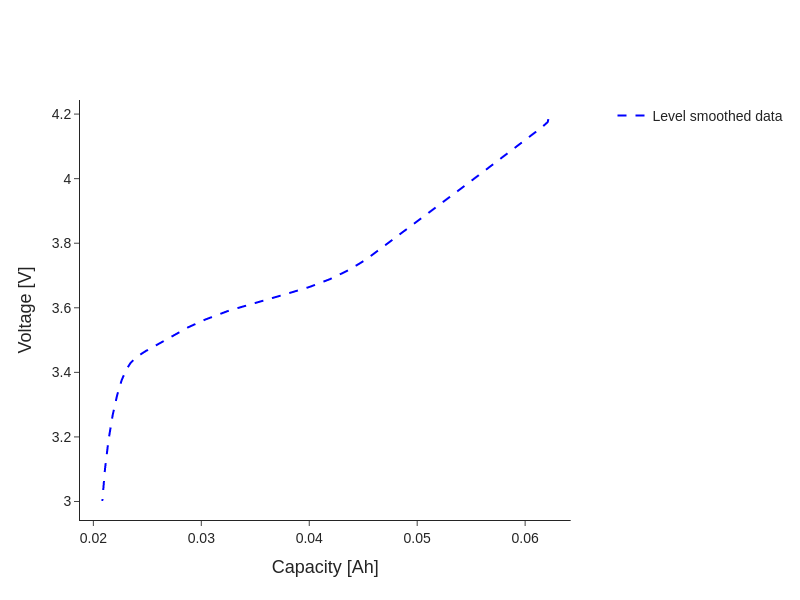

In [4]:
from pyprobe.analysis import smoothing


downsampled_data = smoothing.downsample(input_data = final_cycle.discharge(0),
                                            target_column='Voltage [V]',
                                                  sampling_interval=0.002,
                                                )
fig = pyprobe.Plot()
# fig.add_line(final_cycle.discharge(0), 'Capacity [Ah]', 'Voltage [V]', label='Raw data', color='red',)
fig.add_line(downsampled_data, 'Capacity [Ah]', 'Voltage [V]', label='Level smoothed data', color='blue', dash='dash')
fig.show_image()

We can now differentiate the smoothed data object:

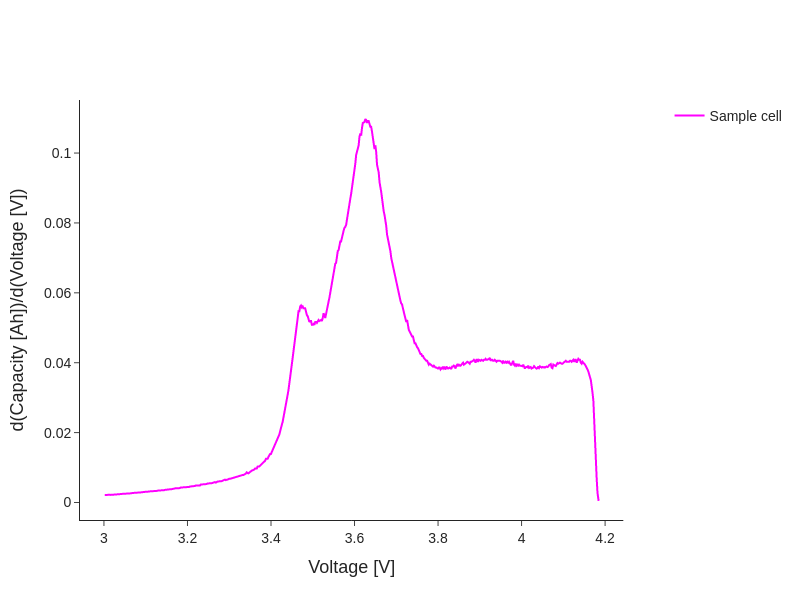

In [5]:
downsampled_data_dVdQ = differentiation.gradient(downsampled_data, "Voltage [V]", "Capacity [Ah]")

fig = pyprobe.Plot()
fig.add_line(downsampled_data_dVdQ, 'Voltage [V]', 'd(Capacity [Ah])/d(Voltage [V])')
fig.show_image()

PyProBE has multiple smoothing methods, so you can easily compare their effect on the ICA result:

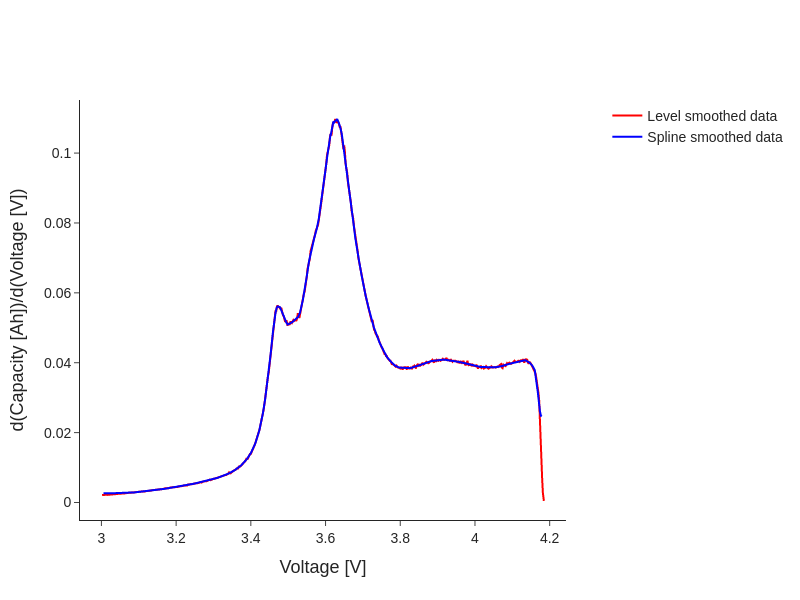

In [6]:
spline_smoothed_data = smoothing.spline_smoothing(input_data = final_cycle.discharge(0),
                                                  x='Capacity [Ah]',
                                                  target_column='Voltage [V]',
                                                  smoothing_lambda=1e-10,
                                                  )   
spline_smoothed_data_dVdQ = differentiation.gradient(spline_smoothed_data,"Voltage [V]","Capacity [Ah]")



fig = pyprobe.Plot()
fig.add_line(downsampled_data_dVdQ, 'Voltage [V]', 'd(Capacity [Ah])/d(Voltage [V])', label='Level smoothed data', color='red')
fig.add_line(spline_smoothed_data_dVdQ, 'Voltage [V]', 'd(Capacity [Ah])/d(Voltage [V])', label='Spline smoothed data', color='blue')
fig.show_image()


We can also compare to an alternative differentiation method, the LEAN method described in Feng X, Merla Y, Weng C, Ouyang M, He X, Liaw BY, et al. A reliable approach of differentiating discrete sampled-data for battery diagnosis. eTransportation. 2020;3: 100051. https://doi.org/10.1016/j.etran.2020.100051.

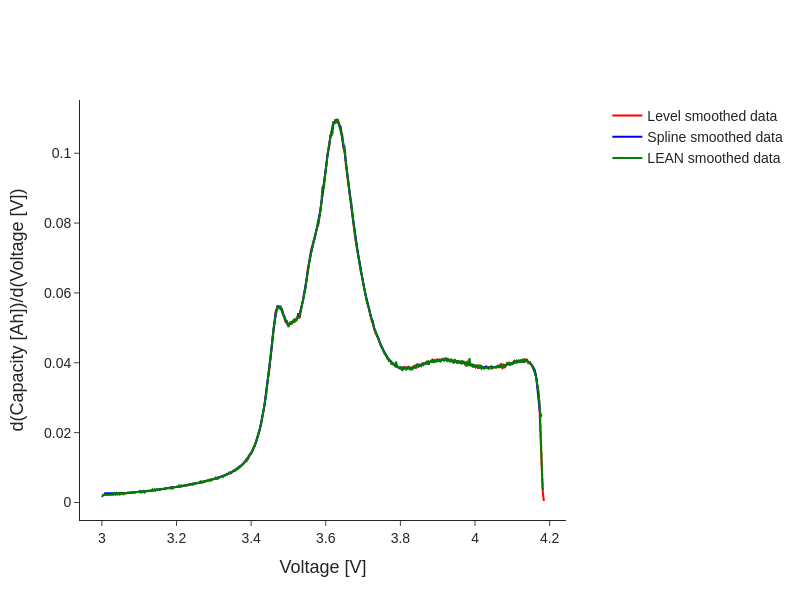

In [7]:
LEAN_dQdV = differentiation.differentiate_LEAN(input_data = final_cycle.discharge(0), x = 'Capacity [Ah]', y='Voltage [V]', k = 10, gradient = 'dxdy')

fig = pyprobe.Plot()
fig.add_line(downsampled_data_dVdQ, 'Voltage [V]', 'd(Capacity [Ah])/d(Voltage [V])', label='Level smoothed data', color='red')
fig.add_line(spline_smoothed_data_dVdQ, 'Voltage [V]', 'd(Capacity [Ah])/d(Voltage [V])', label='Spline smoothed data', color='blue')
fig.add_line(LEAN_dQdV, 'Voltage [V]', 'd(Capacity [Ah])/d(Voltage [V])', label='LEAN smoothed data', color='green')
fig.show_image()